In [ ]:
import sys
!{sys.executable} -m pip install pybaseball

# Exploring Relative Correlations of Average and Total WAR vs Wins

My initial hypothesis is that average wins above replacement, WAR, is a better predictor of win percentage than total WAR. For this analysis I am going to be using Baseball Refrence Wins Above Replacement, bWAR, as the data is more accessable and easier to manipulate for my purposes. I am also going to compare these with the toal and average. For my data to be significatn i am going to use the standard p-value of .01.

In [1]:
#Import base libraries
import pandas as pd
from pybaseball import *

In [2]:
#Get batter and pitcher bWAR
bwar_bat_data = bwar_bat()
bwar_pitch_data = bwar_pitch()


## Preparing the data to graph

### Output Data Frame
The first thing to do is to create a pandas DataFrame to store the data that is needed.

### Data to include
#### Data Sets
I decided to use the live ball era. This is from 1920 onward, because before 1920 the rules were sufficently different that i believe that the data was not applicable. Also i decided to only use the AL and NL because there are some issues with the data for the Negro Leauges that made it hard to add to the set. 
#### Issues with baseball
The next issues was how to deal with some of the issues that baseball has. The first is what to do about The Designated Hitter. The issue is that becuase it is not in all of the data points it can cause some extra noise. The second is what to do with the pitching WAR of position players that pitch. I decided that overall it was worth it to keep both, as the data sets have that as a feature. 

The data is all calculated at this point.

In [3]:
war_data = pd.DataFrame(columns = ['Team', 'Year', 'WinPercent', 'HadDH', 'TotalAvgWAR', 'BattingAvgWAR', 'PitchingAvgWAR', 'TotalWAR', 'TotalBattingWAR', 'TotalPitchingWAR'])

# Loop Through the years
for year in range(1920, 2021):
    # Get all data for teams from a year
    teams = team_ids(year)
    bat_war = bwar_bat_data.loc[(bwar_bat_data['year_ID'] == year) & ((bwar_bat_data['lg_ID'] == 'NL') | (bwar_bat_data['lg_ID'] == 'AL'))]
    pitch_war = bwar_pitch_data.loc[(bwar_pitch_data['year_ID'] == year) & ((bwar_pitch_data['lg_ID'] == 'NL') | (bwar_pitch_data['lg_ID'] == 'AL'))]
    total_war = bat_war.append(pitch_war, ignore_index=True, sort=False)
    # Loop Through each team
    for team in teams.itertuples(index=False):
        teamIDBR = team[teams.columns.get_loc("teamIDBR")]
        record_objs = schedule_and_record(year, teamIDBR).iloc[-1]['W-L'].split('-')
        record_objs = list(map(int, record_objs))
        win_percent = record_objs[0] / (record_objs[0] + record_objs[1])
        team_bat_war = bat_war.loc[bat_war['team_ID'] == teamIDBR]
        team_pitch_war = pitch_war.loc[pitch_war['team_ID'] == teamIDBR]
        team_total_war = total_war.loc[total_war['team_ID'] == teamIDBR]
        had_dh = True if team[teams.columns.get_loc("lgID")] == 'AL' and year >= 1973 else False
        # Add each teams WAR data to chart
        row = [teamIDBR, year, win_percent, had_dh, team_bat_war.WAR.mean(), team_bat_war.WAR.mean(), team_pitch_war.WAR.mean(),  team_total_war.WAR.sum(), team_bat_war.WAR.sum(), team_pitch_war.WAR.sum()]
        war_data.loc[len(war_data.index)] = row

# Get a sample of the data
war_data.sample(5)

/home/fkatz/baseballWAR/venv_baseballWAR/lib/python3.8/site-packages/pybaseball/team_results.py:70: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = data.drop('',1) #not a useful column
/home/fkatz/baseballWAR/venv_baseballWAR/lib/python3.8/site-packages/pybaseball/team_results.py:83: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = data.drop('Streak2',1)


,Team,Year,WinPercent,HadDH,TotalAvgWAR,BattingAvgWAR,PitchingAvgWAR,TotalWAR,TotalBattingWAR,TotalPitchingWAR
366,PIT,1942,0.448980,False,0.304412,0.304412,0.773333,21.95,10.35,11.60
793,STL,1967,0.627329,False,1.028333,1.028333,1.186923,46.28,30.85,15.43
166,SLB,1930,0.415584,False,0.335484,0.335484,1.319000,23.59,10.40,13.19
652,PHI,1960,0.383117,False,0.089250,0.089250,1.080625,20.86,3.57,17.29
1085,BOS,1980,0.518750,True,0.774333,0.774333,0.724118,35.54,23.23,12.31


In [4]:
#Import graphing and statistical functions
import numpy as np
from numpy.polynomial.polynomial import Polynomial
import matplotlib.pyplot as plt
import scipy.stats

#Get column sets for different chars
xcolset = ['WinPercent', 'WinPercent', 'WinPercent', 'WinPercent', 'WinPercent', 'WinPercent']
ycolset = ['TotalAvgWAR', 'BattingAvgWAR', 'PitchingAvgWAR', 'TotalWAR', 'TotalBattingWAR', 'TotalPitchingWAR']
xlabelset = ['Win Percentage', 'Win Percentage', 'Win Percentage', 'Win Percentage', 'Win Percentage', 'Win Percentage']
ylabelset = ['Team Average bWAR', 'Batting Average bWAR', 'Pitching Average bWAR', 'Total Team bWAR', 'Total Batting bWAR', 'Total Pitching bWAR']

#Define plotting function
def plot_chart(chartNum, xcol, ycol, xlabel, ylabel):

    xcoldata = war_data[xcol]
    ycoldata = war_data[ycol]
    
    offset, slope = Polynomial.fit(xcoldata, ycoldata, 1).convert().coef
    correlation =  scipy.stats.pearsonr(xcoldata, ycoldata)
    
    plt.figure(chartNum, figsize=(19.20,10.80))
    plt.rcParams['font.size'] = '16'
    plt.scatter(xcoldata, ycoldata, c=xcoldata, s=20, cmap='gnuplot')
    plt.plot(xcoldata, offset + slope * xcoldata, '-', c='black')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    title_string = f'{xlabel} vs {ylabel}'
    plt.title(title_string, fontsize=20)
    
    axes = plt.gca()
    xmin, xmax = axes.get_xlim()
    ymin, ymax = axes.get_ylim()
    textxpos = .05
    textypos = .9
    
    plt.text(((xmax-xmin)*textxpos) + xmin, ((ymax-ymin)*textypos) + ymin, f'correlation = {correlation[0]} \np-value = {correlation[1]}')
    
    plt.savefig(f'{title_string}.png', dpi = 300)
    plt.show()
    


## Plotted Charts

### Information about data points

#### Correlation
The corelation number in all of these graphs is a measure of the quality of the correlation between the two axis. A number closer to 1 means that there is a higher correlation, a number closer to 0 means that there is a lower correlation. A number closer to -1 means there is a higher inverse correlation. 

#### p-value
The p value is the meauser of how likely it is that this data occured by random chance. A lower value means that the likeleyhood of this result being random is very low.

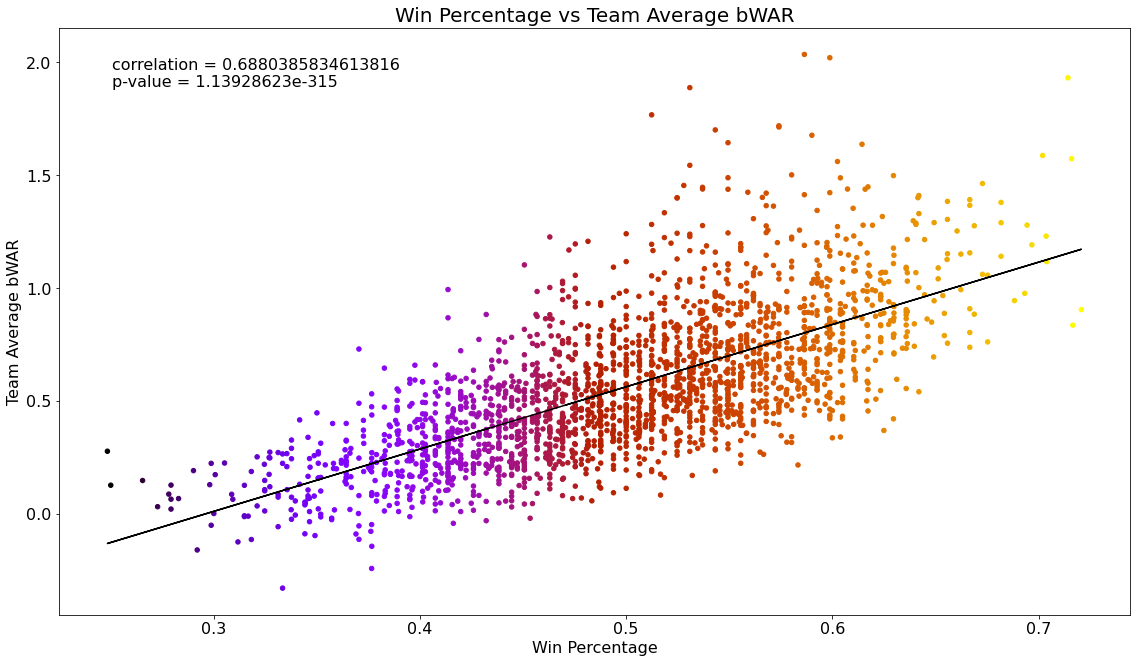

In [5]:
plot_chart(0, xcolset[0], ycolset[0], xlabelset[0], ylabelset[0])

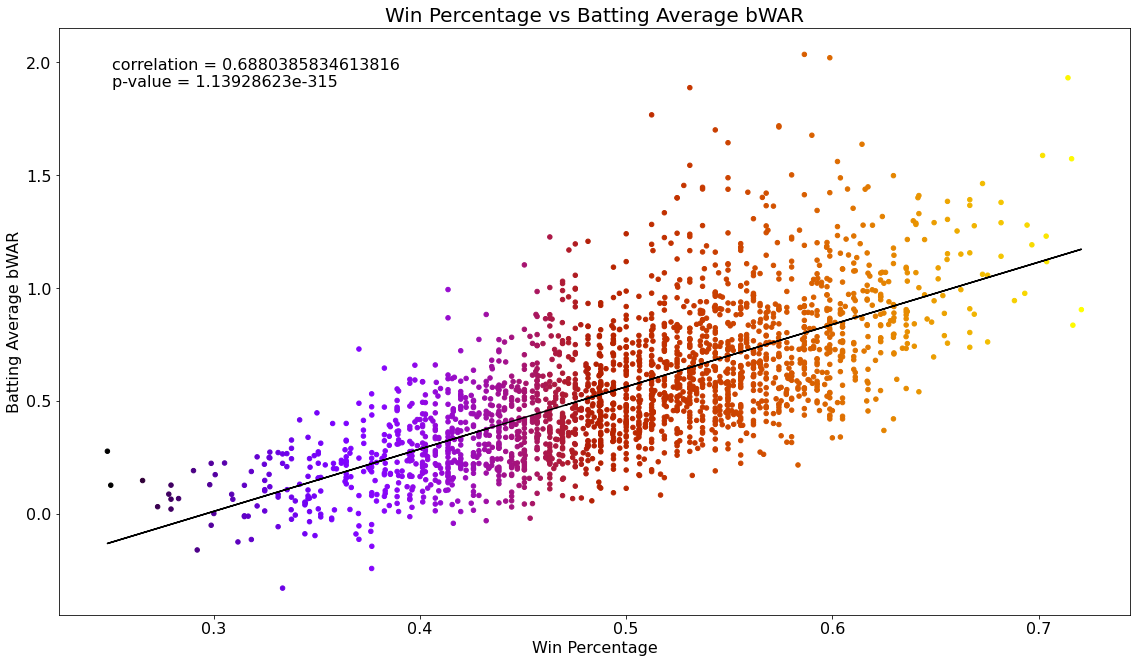

In [6]:
plot_chart(1, xcolset[1], ycolset[1], xlabelset[1], ylabelset[1])

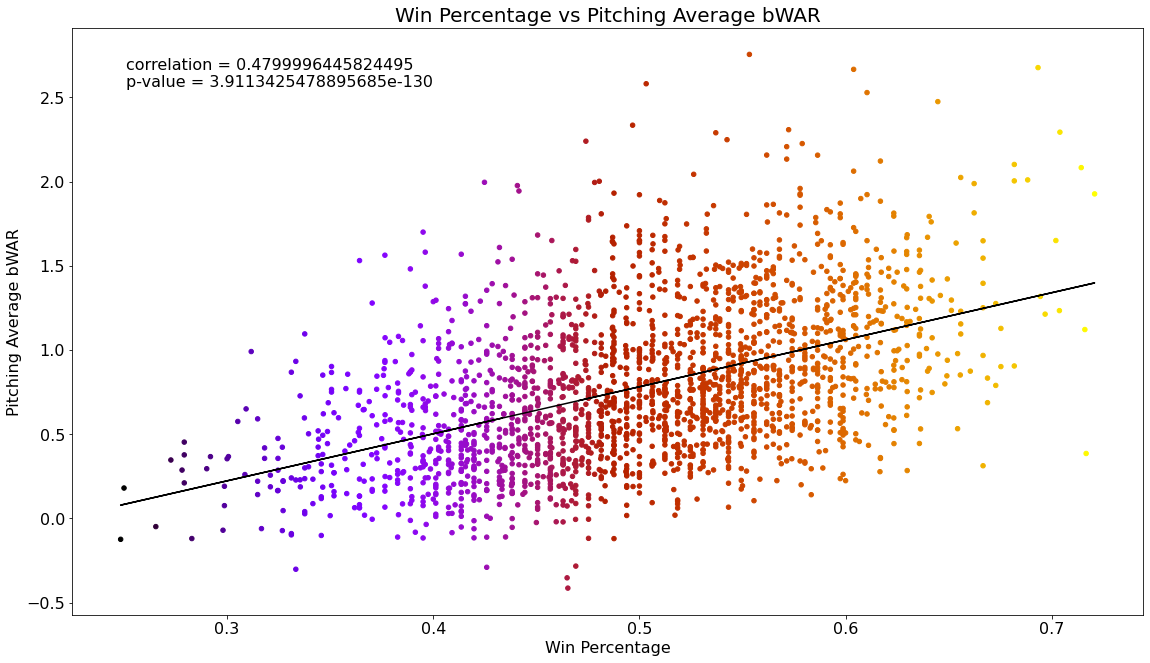

In [7]:
plot_chart(2, xcolset[2], ycolset[2], xlabelset[2], ylabelset[2])

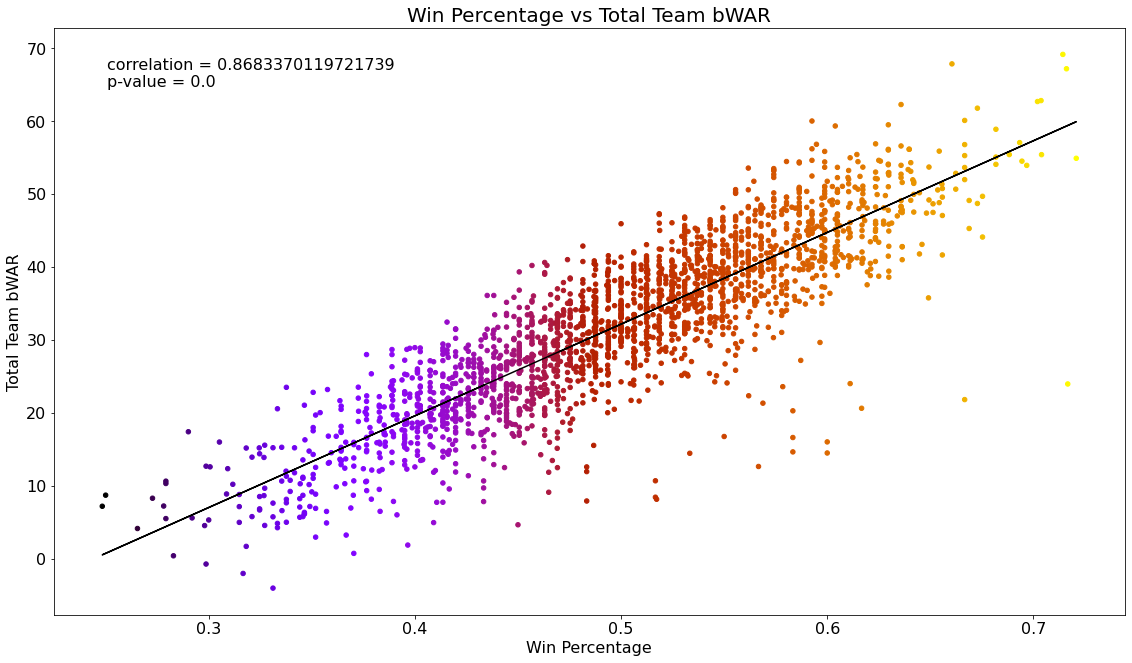

In [8]:
plot_chart(3, xcolset[3], ycolset[3], xlabelset[3], ylabelset[3])

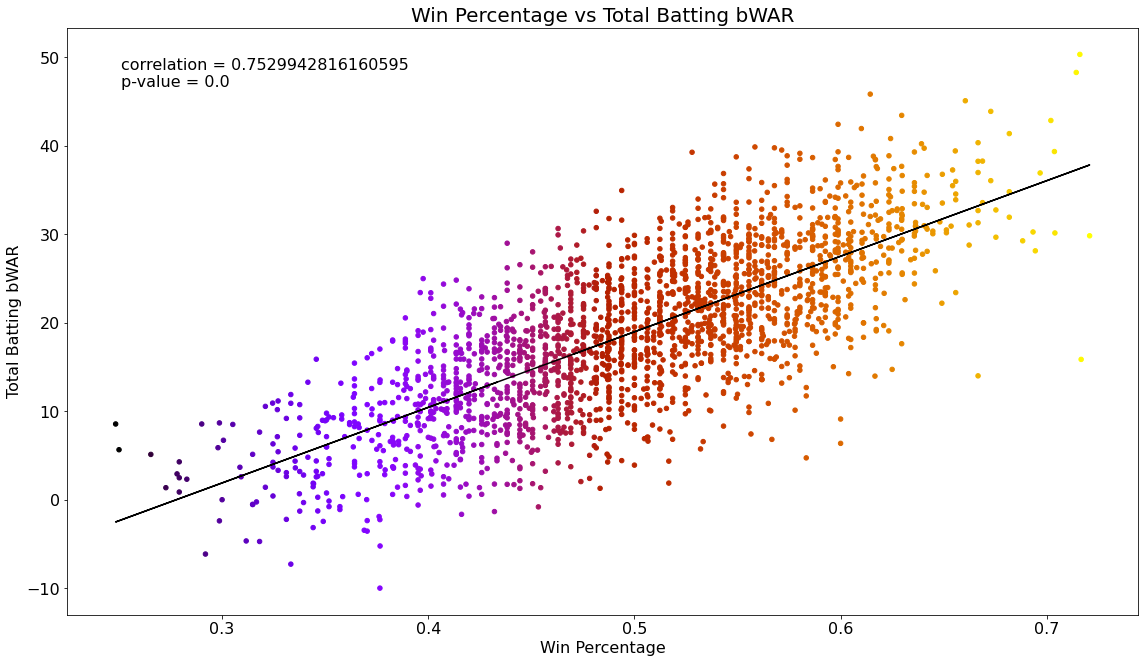

In [9]:
plot_chart(4, xcolset[4], ycolset[4], xlabelset[4], ylabelset[4])

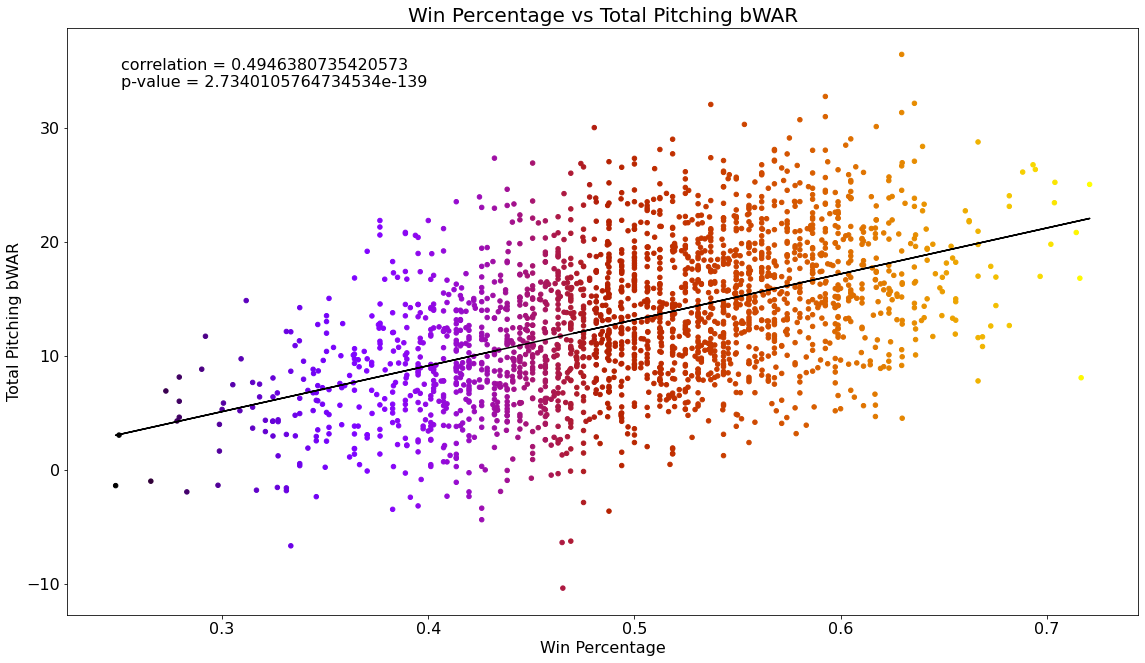

In [10]:
plot_chart(5, xcolset[5], ycolset[5], xlabelset[5], ylabelset[5])

## Data Analysis

### Pitching and batting war vs equivalent totals

The correlation values above show that the pitching and batting bWARs individually are worse indications of correlation than the Team bWAR. I belive that this is because it give a picture of only part of the game. It is very possible for a team to be good at pitching and bad at batting, or the reverse, and their win percentage may not reflect that. 

### Total Team War vs Average Team War

The correlation values in the graphs show that Total Team bWAR is a better indication of win percentage. I believe that this is beacuse the average bWAR can hide mediocre teams with a small number of very good players, but Total bWAR excentuates teams that are very good overall. 

## Conclusions
My conclusion is that my initial Hypothesis is incorrect. Total war is a better metric to predict wins than average wins. We can tell that this result is not a result of randomness, as all my p-values are below .01 making the results statistically significant.